# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [4]:
!pip install sentencepiece

In [5]:
import torch
import numpy as np
from dataset import TextDataset

C:\Users\Stepan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='word', model_type='bpe', vocab_size=5000)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='word', model_type='bpe', vocab_size=5000)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)

In [7]:
print(len(train_set) + len(valid_set))
for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

120759


## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [8]:
from model import LanguageModel

In [9]:
model = LanguageModel(train_set).to(device)

In [10]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [11]:
from train import train
import torch.nn as nn

In [12]:
model_rnn = LanguageModel(train_set).to(device)
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=1e-4, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9999)

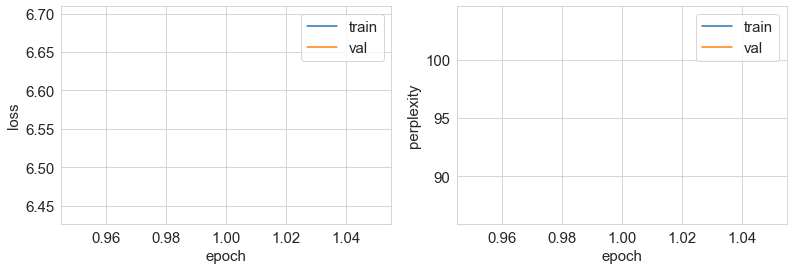

Generation examples:
- не нужно дваловла, место берут получаетсяванияюскиках.

купил мужик шляпу, что дорогой рал- первую? ч- мы самый пла до. правитель прошло.

сел медведь в машину и в пи, заченом сегодня га. рабо морящегочала.- пей, поло теперь достанами набира придумалин никто.

подумал штирлиц, такцы оху соешь. ты опла обиныммашен...



In [13]:
train(model=model_rnn, optimizer=optimizer,
          train_loader=train_loader, val_loader=val_loader, num_epochs= 1, num_examples=5, scheduler=None)

In [14]:
torch.save(model_rnn.state_dict(), 'model_rnn_checkpoint.pth')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [15]:
model_lstm = LanguageModel(train_set, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=1e-3,weight_decay=0.0001 )
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)

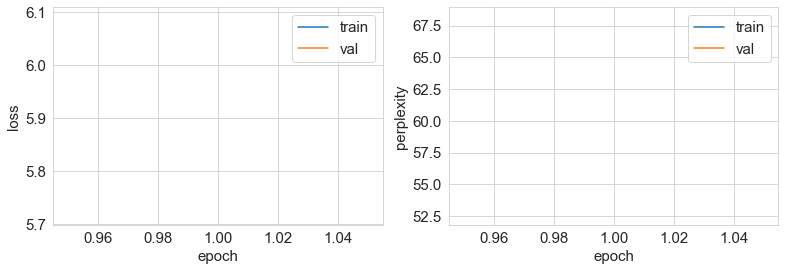

Generation examples:
- как вы работкаянопали?- первым?- да, а какая опять тебе. ец от кабви налижку своей о том?

купил мужик шляпу, что не бог маленькая глупо добнисть выкоеть, кто уже и стоятьлую...

сел медведь в машину и не было получил лонете своего на неболье подороена и все-таки у негонию тетная увершу поставил.

подумал штирлиц, просто нужно ввасах заводере предгромдки.



In [16]:
train(model=model_lstm, optimizer=optimizer,
          train_loader=train_loader, val_loader=val_loader, num_epochs= 1, num_examples=5, scheduler=scheduler)

In [17]:
torch.save(model_lstm.state_dict(), 'model_lstm_checkpoint.pth')

In [18]:
'''from GPTModel import TransformerModel
from torch.optim.lr_scheduler import SequentialLR, ExponentialLR
#scheduler1 = ExponentialLR(optimizer, gamma=1.008)
scheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-10, max_lr=1e-3, step_size_up=1000, cycle_momentum=False)
scheduler2 = ExponentialLR(optimizer, gamma=0.9999)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002, total_steps = 90*120759//128)'''

'from GPTModel import TransformerModel\nfrom torch.optim.lr_scheduler import SequentialLR, ExponentialLR\n#scheduler1 = ExponentialLR(optimizer, gamma=1.008)\nscheduler1 = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-10, max_lr=1e-3, step_size_up=1000, cycle_momentum=False)\nscheduler2 = ExponentialLR(optimizer, gamma=0.9999)\nscheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.002, total_steps = 90*120759//128)'

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [19]:
for prefix in ['купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц', 'штирлиц ', 'колобок ']:

    generated = model_lstm.inference(prefix, temp=0.4)
    print(generated)
    print()

купил мужик шляпу, что он не в россии, а не поделить.

сел медведь в машину и не может быть и не могу.

подумал штирлиц, что у вас в россии - это когда ты не было, а я - как-то, но в чем будет не будет.

штирлиц, что в россии не было, как лучше забили.

колобок - это когда-то не в жизни, то же, что у тебя есть в жизни, а я не до сих пор, а если не был все.



## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [20]:
torch.cuda.empty_cache()

In [21]:
train_set_bpe = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', vocab_size=3000)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', vocab_size=3000)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=False)

In [22]:
model_bpe = LanguageModel(train_set_bpe, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_bpe.parameters(), lr=1e-4, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [23]:
train(model=model_bpe, optimizer=optimizer,
          train_loader=train_loader, val_loader=val_loader, num_epochs= 1, num_examples=3, scheduler=None, temp=0.5)

Training 1/1:   0%|          | 0/1793 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.save(model_bpe.state_dict(), 'model_bpe_3000_checkpoint.pth')

In [ ]:
train_set_unigram = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', vocab_size=5000)
valid_set_unigram = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=5000)
train_loader_unigram = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
val_loader_unigram = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=False)

In [ ]:
model_unigram = LanguageModel(train_set_unigram, rnn_layers=1, rnn_type=nn.LSTM).to(device)
optimizer = torch.optim.Adam(model_unigram.parameters(), lr=1e-5, weight_decay=0.00001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

In [ ]:
train(model=model_unigram, optimizer=optimizer,
          train_loader=train_loader_unigram, val_loader=val_loader_unigram, num_epochs= 1, 
    num_examples=5, scheduler=scheduler, temp=0.5)

In [ ]:
torch.save(model_unigram.state_dict(), 'model_unigram_checkpoint.pth')

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [ ]:
def get_cosine_sim(model):
    gen_sample = []
    valid_sample = []
    for i in range(len(valid_set)):
        gen_sample.append(model.inference())
        valid_sample.append(train_set.ids2text(valid_set[i][0]))
    vectorizer = TfidfVectorizer()
    vectorizer.fit(gen_sample+valid_sample)
    valid_X = vectorizer.transform(valid_sample)
    gen_X = vectorizer.transform(gen_sample)
    svd = TruncatedSVD(n_components=5, n_iter=100, random_state=42)
    valid_X_svd = svd.fit_transform(valid_X)
    gen_X_svd = svd.transform(gen_X)
    cosine_similarity = (valid_X_svd*gen_X_svd).sum(axis=1)/(np.linalg.norm(valid_X_svd, axis=1)\
                                                             *np.linalg.norm(gen_X_svd,  axis=1))
    return np.nanmean(cosine_similarity), valid_X, gen_X

In [ ]:
model = LanguageModel(train_set).to(device)
model.load_state_dict(torch.load('model_rnn_checkpoint.pth'))
cos1, valid_X, gen_X = get_cosine_sim(model)

In [ ]:
model = LanguageModel(train_set, rnn_layers=1, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('model_lstm_checkpoint.pth'))
cos2, _ , _ = get_cosine_sim(model)

In [ ]:
model = LanguageModel(train_set_bpe, rnn_layers=1, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('model_bpe_3000_checkpoint.pth'))
cos3, _, _ = get_cosine_sim(model)

In [ ]:
model = LanguageModel(train_set_unigram, rnn_layers=1, rnn_type=nn.LSTM).to(device)
model.load_state_dict(torch.load('model_unigram_checkpoint.pth'))
cos4, _, _ = get_cosine_sim(model)

In [ ]:
model_bpe.dataset.vocab_size

In [ ]:
train_set_bpe.vocab_size

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
valid_X.shape

In [ ]:
def plt_v(valid_X, gen_X):
    tsne = TSNE(n_components=2, learning_rate='auto',
                 init='random', perplexity=3)
    valid_embedded = tsne.fit_transform(valid_X)
    gen_embedded = tsne.fit_transform(gen_X)
    print(valid_embedded.shape, valid_X.shape)
    plt.figure(figsize=(14, 7))
    plt.scatter(valid_embedded[:, 0], valid_embedded[:,1], label='valid')
    plt.scatter(gen_embedded[:,0], gen_embedded[:,1], label='gen')
    plt.legend()
    plt.show()
    

In [ ]:
plt_v(valid_X, gen_X)

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:

tokenizer = GPT2Tokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
model = GPT2LMHeadModel.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")


input_text = 'сел медведь в машину'
input_ids = tokenizer.encode(input_text, return_tensors="pt")
attention_mask = torch.ones(input_ids.shape, dtype=torch.long)
output = model.generate(input_ids, attention_mask=attention_mask, max_length=100, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id)
gen_text = tokenizer.decode(output[0], skip_special_tokens=True)
gen_text




In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Optional, Any
from torch import nn
from torch.utils.data import DataLoader
from IPython.display import clear_output
from tqdm.notebook import tqdm
from model import LanguageModel
import numpy as np

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses: List[float], val_losses: List[float]):

    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    train_perplexities, val_perplexities = [], []
    train_perplexities = np.power([2]*len(train_losses), train_losses)
    val_perplexities = np.power([2]*len(val_losses), val_losses)

    axs[1].plot(range(1, len(train_perplexities) + 1), train_perplexities, label='train')
    axs[1].plot(range(1, len(val_perplexities) + 1), val_perplexities, label='val')
    axs[1].set_ylabel('perplexity')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


def training_epoch(model: LanguageModel, optimizer: torch.optim.Optimizer, criterion: nn.Module,
                   loader: DataLoader, tqdm_desc: str, scheduler):

    device = next(model.parameters()).device
    train_loss = 0.0

    model.train()
    for indices, lengths in tqdm(loader, desc=tqdm_desc):
        
        optimizer.zero_grad()
        indices = indices.to(device)
        #print(indices)
        logits = model(indices[:, :-1])
        
        loss = criterion(logits.transpose(1,2), indices[:, 1:])
        print(loss.item())
        #print(model.decoder[0].attention.attention_heads[0].Wq.weight) 
        loss.backward()
        #print(model.decoder[0].attention.attention_heads[0].Wq.weight) 
        optimizer.step()
        if scheduler:
            scheduler.step()
            print(scheduler.get_last_lr())
        train_loss+=loss.item()      
            
    train_loss /= len(loader.dataset)
    return train_loss*loader.batch_size


@torch.no_grad()
def validation_epoch(model: LanguageModel, criterion: nn.Module,
                     loader: DataLoader, tqdm_desc: str):

    device = next(model.parameters()).device
    val_loss = 0.0

    model.eval()
    for indices, lengths in tqdm(loader, desc=tqdm_desc):
        
        tokens = indices.to(device)
        logits = model(tokens[:, :-1])
        
        loss = criterion(logits.transpose(1,2), tokens[:, 1:])
        val_loss += loss.item()

    val_loss /= len(loader.dataset)
    return val_loss*loader.batch_size


def train(model: LanguageModel, optimizer: torch.optim.Optimizer, scheduler: Optional[Any],
          train_loader: DataLoader, val_loader: DataLoader, num_epochs: int, num_examples=2, temp=1):

    train_losses, val_losses = [], []
    criterion = nn.CrossEntropyLoss(ignore_index=train_loader.dataset.pad_id)

    for epoch in range(1, num_epochs + 1):
        train_loss = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}', scheduler=scheduler
        )
        val_loss = validation_epoch(
            model, criterion, val_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )



        train_losses += [train_loss]
        val_losses += [val_loss]
        plot_losses(train_losses, val_losses)

        print('Generation examples:')
        for _ in range(1):
            print(model.generate())
            print()
        for prefix in [ 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:

            generated = model.generate(prefix)
            print(generated)
            print()

In [ ]:
train(model=model_unigram, optimizer=optimizer,
          train_loader=train_loader, val_loader=val_loader, num_epochs= 12, num_examples=5, scheduler=scheduler, temp=0.5)

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.